In [10]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

import keras2
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
from util import moving_average, dlqr, discretized_system, lqr
import gym2
from rl2.agents import DDPGAgent
from rl2.memory import SequentialMemory

In [2]:
# GymのPendulum環境を作成
dt = 0.05
env = gym2.make("Pendulum-v1", dt)
clip = 10.
env.max_torque, max_torque = clip, clip
env.action_space.high, env.action_space.low = max_torque, -max_torque
control_interval = 5

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [7]:
def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(2, activation="multiple_tanh")(x)
    actor = Model(inputs=action_input, outputs=x)
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

In [8]:
def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = DDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory
    )
    return agent

In [9]:
#safe learning
step = 300000
episode_step = int(200 * 0.05 / (dt * control_interval)) # 入力が加えられる回数を200(dt=0.05)にする
a = agent((2,), (2,))
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
# a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
# a.load_weights('../../learned_models_stab/lqr_optimal_agent.h5')
out = a.fit(env, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step, action_repetition=control_interval)

episode_rewards = out.history["episode_reward"]

Training for 300000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 43s 4ms/step - reward: -19.7101
250 episodes - episode_reward: -788.404 [-1645.418, -547.035] - loss: 105.783 - mean_absolute_error: 11.230 - mean_q: -69.461

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 45s 5ms/step - reward: -17.2953
250 episodes - episode_reward: -691.811 [-1318.582, -485.852] - loss: 241.640 - mean_absolute_error: 12.735 - mean_q: -156.838

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 46s 5ms/step - reward: -19.7781
250 episodes - episode_reward: -791.122 [-1378.673, -387.353] - loss: 443.459 - mean_absolute_error: 14.323 - mean_q: -227.057

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 47s 5ms/step - reward: -18.3857
250 episodes - episode_reward: -735.430 [-1128.372, -534.060] - loss: 678.321 - mean_absolute_error: 15.655 - mean_q: -291.773

Interva

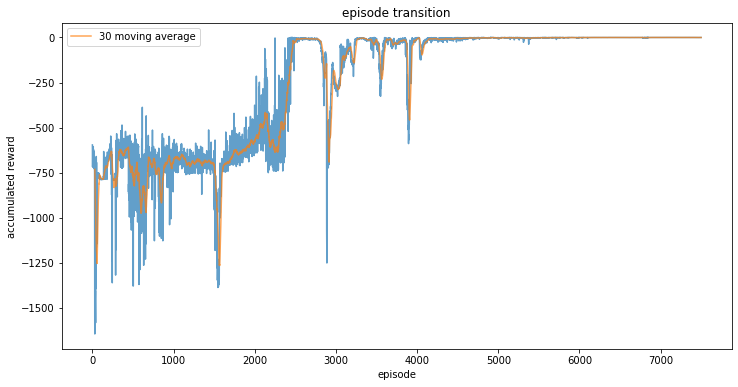

In [37]:
lma = 30
plt.figure(figsize=(12,6))
ma = moving_average(episode_rewards, lma)
plt.plot(range(len(episode_rewards)), episode_rewards, alpha=0.7)
plt.plot(range(lma, len(episode_rewards)), ma, label=f'{lma} moving average', alpha=0.7)
plt.xlabel('episode')
plt.ylabel('accumulated reward')
plt.title('episode transition')
plt.legend()
plt.show()

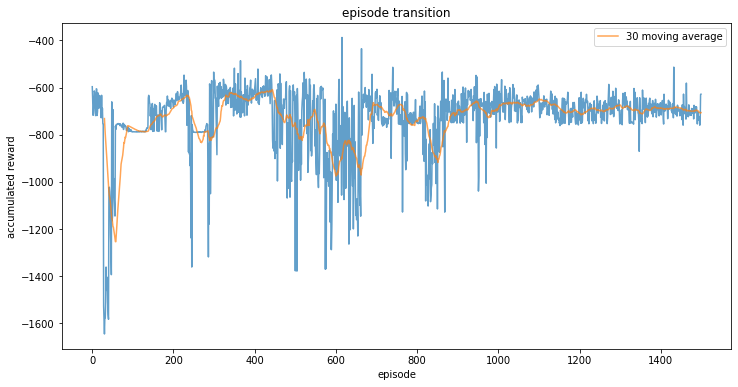

In [42]:
lma = 30
episode_rewards_ = episode_rewards[:int(episode_rewards.shape[0]/5)]
plt.figure(figsize=(12,6))
ma = moving_average(episode_rewards_, lma)
plt.plot(range(len(episode_rewards_)), episode_rewards_, alpha=0.7)
plt.plot(range(lma, len(episode_rewards_)), ma, label=f'{lma} moving average', alpha=0.7)
plt.xlabel('episode')
plt.ylabel('accumulated reward')
plt.title('episode transition')
plt.legend()
plt.show()

In [16]:
import csv
with open('./csv/episode_rewards_5.csv', 'r') as f:
    reader = csv.reader(f)
    episode_rewards = [row for row in reader][0]
    episode_rewards = np.array(episode_rewards).astype('float64')
print(episode_rewards)

[-5.96205446e+02 -6.48061968e+02 -7.17663306e+02 ... -2.28158579e-01
 -1.51414384e-01 -1.52770637e-01]
